In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
import os
import shutil
import random
from pathlib import Path

# Define source and destination directories
source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir = '/kaggle/working/plantvillage-balanced'

# Create destination directory
os.makedirs(dest_dir, exist_ok=True)

# Step 1: Get all classes (folders) and image counts
class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

# Step 2: Determine the minimum number of images
min_count = min(class_counts.values())
print("Minimum number of images in any class:", min_count)

# Step 3: Downsample each class and copy to destination
for class_name in class_counts:
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)
    os.makedirs(dst_class_path, exist_ok=True)

    image_files = [f for f in os.listdir(src_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sampled_files = random.sample(image_files, min_count)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

print("Balanced dataset created at:", dest_dir)


Minimum number of images in any class: 152
Balanced dataset created at: /kaggle/working/plantvillage-balanced


In [4]:
# Define data transformations

# Otherwise use the following structure

# Define transformations with potential augmentations

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      # Resize and crop for augmentation
    transforms.RandomHorizontalFlip(),      # Augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply test transformation to validation and test sets

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

In [5]:
class_names = dataset.classes
num_classes = len(class_names)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output shape: [batch, 256, 1, 1]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),          # [batch, 256]
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [7]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [8]:


from tqdm import tqdm  # Import tqdm for progress bars
from torch.cuda.amp import autocast, GradScaler  # Import AMP utilities

# Set number of epochs and initialize variables

num_epochs = 50  # Define the number of training epochs

model = CustomCNN(num_classes=num_classes).to('cuda')  # Move model to GPU

criterion = nn.CrossEntropyLoss()  # Loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer with learning rate

early_stopping = EarlyStopping(patience=5)  # Initialize early stopping with patience

train_losses, val_losses = [], []  # Lists to store training and validation losses per epoch

# Initialize GradScaler for AMP
scaler = GradScaler()
# Loop over epochs
for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training phase
    model.train()  # Set model to training mode
    train_loss = 0  # Initialize cumulative training loss for the epoch
    # Loop over training data with tqdm progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
        optimizer.zero_grad()  # Clear previous gradients
        with autocast():  # Use AMP for mixed-precision calculations
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

        # Scale loss to avoid underflow for float16
        scaler.scale(loss).backward()  # Backward pass with scaled loss
        scaler.step(optimizer)  # Optimizer step
        scaler.update()  # Update the scaler for next iteration
        train_loss += loss.item()  # Accumulate the training loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0  # Initialize cumulative validation loss for the epoch
    with torch.no_grad():  # Disable gradient calculation for validation
        # Loop over validation data with tqdm progress bar
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
            with autocast():  # Use AMP for mixed-precision calculations
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item()  # Accumulate the validation loss

    # Calculate average losses and append to lists
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break



/tmp/ipykernel_36/386367400.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/127 [00:00<?, ?it/s]/tmp/ipykernel_36/386367400.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations
Validation:   0%|          | 0/37 [00:00<?, ?it/s]         /tmp/ipykernel_36/386367400.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations


Train Loss: 2.7507, Validation Loss: 1.9506
Epoch 2/50


Train Loss: 1.8392, Validation Loss: 1.6455
Epoch 3/50


Train Loss: 1.5496, Validation Loss: 1.3711
Epoch 4/50


Train Loss: 1.3837, Validation Loss: 1.2304
Epoch 5/50


Train Loss: 1.2711, Validation Loss: 1.1307
Epoch 6/50


Train Loss: 1.1918, Validation Loss: 0.9913
Epoch 7/50


Train Loss: 1.0575, Validation Loss: 0.9369
Epoch 8/50


Train Loss: 0.9908, Validation Loss: 0.8248
Epoch 9/50


Train Loss: 0.9154, Validation Loss: 1.1206
Epoch 10/50


Train Loss: 0.8732, Validation Loss: 0.7758
Epoch 11/50


Train Loss: 0.8231, Validation Loss: 0.7729
Epoch 12/50


Train Loss: 0.8069, Validation Loss: 0.6421
Epoch 13/50


Train Loss: 0.7165, Validation Loss: 0.5579
Epoch 14/50


Train Loss: 0.7264, Validation Loss: 0.7044
Epoch 15/50


Train Loss: 0.6715, Validation Loss: 0.6180
Epoch 16/50


Train Loss: 0.6510, Validation Loss: 0.5408
Epoch 17/50


Train Loss: 0.6271, Validation Loss: 0.6307
Epoch 18/50


Train Loss: 0.6188, Validation Loss: 0.6659
Epoch 19/50


Train Loss: 0.5703, Validation Loss: 0.6999
Epoch 20/50


Train Loss: 0.5840, Validation Loss: 0.5868
Epoch 21/50


Train Loss: 0.5696, Validation Loss: 0.5714
Early stopping triggered.


In [9]:
# Define a path for saving the model
model_save_path = "custom_cnn_model.pth"  # You can specify a different path or filename

# Save the model after training completes or early stopping is triggered
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to custom_cnn_model.pth


In [10]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        with autocast():
            outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # Get predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)


/tmp/ipykernel_36/2132857589.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Classification Report:
               precision    recall  f1-score   support

           0     0.8148    0.7333    0.7719        30
           1     0.9545    0.7241    0.8235        29
           2     0.8889    0.9412    0.9143        34
           3     1.0000    0.3226    0.4878        31
           4     0.9062    1.0000    0.9508        29
           5     0.9375    0.9677    0.9524        31
           6     0.8710    0.9310    0.9000        29
           7     1.0000    0.5455    0.7059        33
           8     0.9333    1.0000    0.9655        28
           9     0.6410    0.8333    0.7246        30
          10     0.8788    1.0000    0.9355        29
          11     0.6970    0.7419    0.7188        31
          12     1.0000    0.6452    0.7843        31
          13     0.9444    0.8947    0.9189        38
          14     0.9286    0.8667    0.8966        30
          15     0.8788    1.0000    0.9355        29
          16     0.7826    0.9474    0.8571        38
   

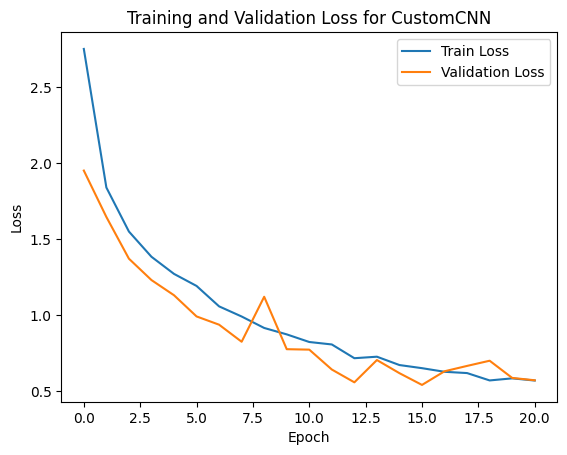

In [13]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()